In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt

### Globals

In [2]:
OUTPUT_PATH = 'outputs/'
FEATURES_PATH = 'features/'
ALGORITHMS = ['bf', 'dp1','greedy', 'bnb', 'cplex']
LEVELS = [1,2,3,4, 5, 6]#,7]#,8]
LEVELS_SIZE = [19198 ,9983, 6664, 4994, 3999, 3333]#, 2857]#, 2500]
FEATURES = ['num_elem',
            'cap',
            'cap_mean_w',
            'cap_median_w', 
            'cap_desv_w', 
            'mean_w_mean_v',
            'median_w_median_v', 
            'desv_w_desv_v',
            'max_w_min_w',
            'max_v_min_v',
            'mean_w',
            'median_w', 
            'desv_w', 
            'min_w', 
            'max_w', 
            'mean_v', 
            'median_v', 
            'desv_v', 
            'min_v', 
            'max_v',
            'p_coef' 
           ]

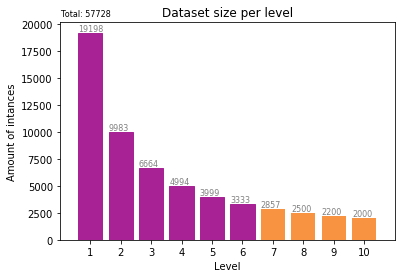

In [3]:
# Plot the feature importances of the forest
FULL_LEVELS_SIZE = [19198 ,9983, 6664, 4994, 3999, 3333, 2857, 2500, 2200, 2000]
plt.figure()
plt.title("Dataset size per level")
plt.title('Total: '+str(sum(FULL_LEVELS_SIZE)), loc='left', fontsize=8)
bars = plt.bar(range(10), FULL_LEVELS_SIZE, color="#f89441")

plt.xticks(range(10), [i+1 for i in range(10)])
plt.xlim([-1, 10])
plt.xlabel("Level")
plt.ylabel("Amount of intances")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 150, yval, color='gray', fontsize=8)

    
for i in range(6):
    bars[i].set_color('#a82296')
    
plt.show()

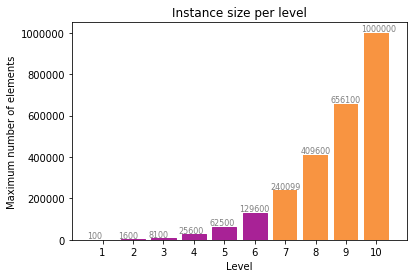

In [26]:
# Plot the feature importances of the forest
a = plt.figure()
plt.title("Instance size per level")
y = [(int)(1000000*((i + 1)/10)**4) for i in range(10)]
bars = plt.bar(range(10), y, color="#f89441")
plt.ticklabel_format(style='plain')
plt.xticks(range(10), [i+1 for i in range(10)])
plt.xlim([-1, 10])
plt.xlabel("Level")
plt.ylabel("Maximum number of elements")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1, yval + 6500, yval, color='gray', fontsize=8)

for i in range(6):
    bars[i].set_color('#a82296')
    
plt.show()
a.savefig("instance_size", bbox_inches = 'tight')

### Helpers

In [5]:
def get_features(lvl, id_):
    return np.array(open(FEATURES_PATH +str(lvl)+'/'+ str(id_),'r').read().split(), dtype=float)

def get_best(lvl, id_, t):
    best_fo = 0
    best_alg = 0
    best_time = 900000
    for alg in ALGORITHMS:
        if lvl not in alg_data[alg].keys(): continue
        if id_ not in alg_data[alg][lvl].keys(): continue
        for res in alg_data[alg][lvl][id_]:
            if res[1] < t:
                if res[0] > best_fo:
                    best_fo = res[0]
                    best_time = res[1]
                    best_alg = ALGORITHMS.index(alg)
                
                elif res[0] == best_fo and res[1] < best_time:
                    best_time = res[1]
                    best_alg = ALGORITHMS.index(alg)
    return best_alg+1

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    plt.xticks(np.arange(6), ["NA",*ALGORITHMS])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Reading outputs

In [4]:
output_files = os.listdir(OUTPUT_PATH)
alg_data = defaultdict(list)

print("Faltan los siguientes resultados:")
for alg in ALGORITHMS:
    alg_data[alg] = defaultdict(list)
    for lvl in LEVELS:
        filename = alg + "_" + str(lvl)
        if filename not in output_files: # En caso de que todavía no hayan resultados
            print(alg, lvl)
            continue
        alg_data[alg][lvl] = defaultdict(list)
        file = open(OUTPUT_PATH+filename,'r')
        for row in file:
            id_, fo, time = row.split()
            alg_data[alg][lvl][int(id_)].append([(float)(fo), (float)(time)])

Faltan los siguientes resultados:


In [105]:
# comparing al ojo
lvl_ = 6
id_ = 33
print("Features: ", get_features(lvl_, id_))
for alg in ALGORITHMS:
    if lvl_ in alg_data[alg]:
        if id_ in alg_data[alg][lvl_]:
            print(alg, alg_data[alg][lvl_][id_])
    
print('BEST: ',ALGORITHMS[get_best(lvl_,id_,1)])

Features:  [ 1.05132000e+05  6.20190000e+04  2.00002931e+00  1.99797043e+00
  3.45401114e+00  4.78519113e-01  4.79146085e-01  4.80291897e-01
  6.20150000e+04  1.29598000e+05  3.10090456e+04  3.10410000e+04
  1.79556456e+04  2.00000000e+00  6.20170000e+04  6.48021046e+04
  6.47840000e+04  3.73848606e+04  1.00000000e+00  1.29599000e+05
 -3.24874867e-03]
greedy [[34786905.0, 0.019811]]
bf [[-1.0, -1.0]]
bnb [[1149655.0, 0.060707], [2109483.0, 0.065099], [3211855.0, 0.069291], [4155209.0, 0.073327], [5204743.0, 0.077353], [6266873.0, 0.081355], [7292631.0, 0.085223], [8004248.0, 0.089095], [8895013.0, 0.092969], [9699179.0, 0.096684], [10687140.0, 0.100405], [11623073.0, 0.104123], [12606337.0, 0.107726], [13531786.0, 0.111307], [14493556.0, 0.114888], [15425104.0, 0.118407], [16337223.0, 0.121858], [17212703.0, 0.125299], [18117885.0, 0.128768], [19117529.0, 0.132109], [19948997.0, 0.135444], [20727484.0, 0.138793], [21592562.0, 0.142105], [22642608.0, 0.145339], [23670397.0, 0.148559], [

In [6]:
max_ = 0

for alg in ALGORITHMS:
    for lvl_ in alg_data[alg].keys():
        for id_ in alg_data[alg][lvl].keys():
            for res in alg_data[alg][lvl_][id_]:
                a = res[1]
                if  a > max_:
                    max_ = a
                    save = [alg, lvl_, id_]

In [9]:
save

['bnb', 4, 2321]

In [30]:
for alg in ALGORITHMS:
    print(alg, len(alg_data[alg][7]))

bf 2857
dp1 1785
greedy 2857
bnb 2857
cplex 0


In [5]:
timesteps = np.logspace(1, 18.4, num=250, base=1.1)-1.1 # escala logaritmica para los tiempos
print(timesteps)

[0.         0.0073507  0.01475053 0.0221998  0.02969886 0.03724802
 0.04484763 0.05249803 0.06019955 0.06795253 0.07575733 0.08361428
 0.09152373 0.09948604 0.10750155 0.11557063 0.12369363 0.13187091
 0.14010284 0.14838977 0.15673208 0.16513014 0.17358432 0.182095
 0.19066254 0.19928734 0.20796978 0.21671023 0.22550909 0.23436675
 0.2432836  0.25226003 0.26129646 0.27039326 0.27955086 0.28876965
 0.29805004 0.30739245 0.31679729 0.32626498 0.33579594 0.34539059
 0.35504935 0.36477265 0.37456094 0.38441463 0.39433417 0.40431999
 0.41437255 0.42449228 0.43467963 0.44493507 0.45525903 0.46565198
 0.47611439 0.4866467  0.49724941 0.50792296 0.51866783 0.52948451
 0.54037348 0.5513352  0.56237018 0.5734789  0.58466185 0.59591954
 0.60725245 0.61866109 0.63014597 0.6417076  0.65334649 0.66506315
 0.67685811 0.68873189 0.70068502 0.71271802 0.72483143 0.73702579
 0.74930164 0.76165952 0.77409998 0.78662358 0.79923086 0.81192239
 0.82469873 0.83756045 0.85050812 0.8635423  0.87666359 0.889872

In [ ]:
train_data = []
train_label = []

count = 0

for lvl in LEVELS:
    print("level "+str(lvl)+"...")
    for id_ in range(LEVELS_SIZE[lvl-1]):
        fts = get_features(lvl, id_)
        for t in timesteps:
            train_data.append([*fts, t+1])
            train_label.append(get_best(lvl, id_, t))
        count += 1

level 1...
level 2...
level 3...


#### Standard Scale: mean=0 and std=1

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
strain_data = scaler.fit_transform(train_data)

#### or... between 0 and 1

In [7]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
strain_data = min_max_scaler.fit_transform(train_data)

## NN

In [6]:
import tensorflow as tf
from keras.layers import Dropout, Dense
from keras import Sequential
from keras import optimizers
from keras.models import Model   
from keras.layers import *
import keras
# Helper libraries
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

/home/miguel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Train and Test set

In [43]:
X_train, X_test, y_train, y_test = train_test_split(strain_data, train_label, test_size=0.3, random_state=42)

### Saving

In [44]:
with open('X_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_train)
with open('X_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_test)
with open('y_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_train)
with open('y_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_test)

### Loading

##### Train set

In [7]:
y_train = np.loadtxt('y_train.csv', dtype=float)
X_train = np.loadtxt('X_train.csv', dtype=float)

###### Test set

In [8]:
X_test = np.loadtxt('X_test.csv', dtype=float)
y_test = np.loadtxt('y_test.csv', dtype=float)

### Model

In [9]:
model = Sequential([
    Dense(128, input_shape = (22,), activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(6, activation='softmax')
])

In [10]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1])

In [12]:
from keras.utils.np_utils import to_categorical
history = model.fit(X_train,to_categorical(y_train), 
                    epochs=10,
                    validation_split=0.3)

Train on 5900947 samples, validate on 2528978 samples
Epoch 1/10
5900947/5900947 [==============================] - 202s 34us/step - loss: 0.8397 - acc: 0.5957 - f1: 0.5628 - val_loss: 0.7993 - val_acc: 0.6065 - val_f1: 0.5780
Epoch 2/10
5900947/5900947 [==============================] - 201s 34us/step - loss: 0.8269 - acc: 0.6026 - f1: 0.5767 - val_loss: 0.7905 - val_acc: 0.6094 - val_f1: 0.5941
Epoch 3/10
5900947/5900947 [==============================] - 201s 34us/step - loss: 0.8231 - acc: 0.6042 - f1: 0.5796 - val_loss: 0.7826 - val_acc: 0.6206 - val_f1: 0.5882
Epoch 4/10
5900947/5900947 [==============================] - 201s 34us/step - loss: 0.8214 - acc: 0.6042 - f1: 0.5793 - val_loss: 0.7838 - val_acc: 0.6080 - val_f1: 0.5931
Epoch 5/10
5900947/5900947 [==============================] - 201s 34us/step - loss: 0.8192 - acc: 0.6040 - f1: 0.5761 - val_loss: 0.7914 - val_acc: 0.6080 - val_f1: 0.5767
Epoch 6/10
5900947/5900947 [==============================] - 201s 34us/step - lo

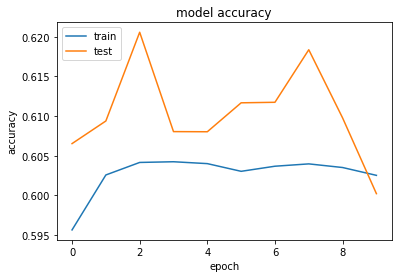

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

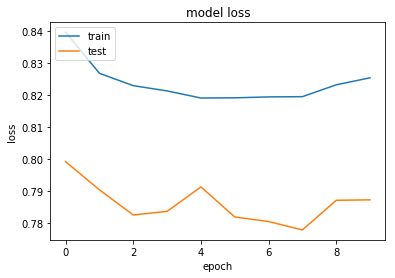

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import f1_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [23]:
forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=0,
                             n_jobs=-1,
                             verbose=1)
forest.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 27.7min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=0, verbose=1, warm_start=False)

In [24]:
forest.score(X_test, y_test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  1.5min finished


0.9932465591330883

In [25]:
pred_eforest = forest.predict(X_test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  1.5min finished


In [26]:
f1_score(y_test, pred_eforest, average='macro') 

0.9738763754606931

In [25]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

NameError: name 'forest' is not defined

NameError: name 'importances' is not defined

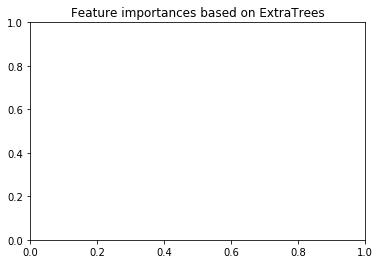

In [24]:
# Plot the feature importances of the forest
a = plt.figure()
plt.title("Feature importances based on ExtraTrees")
plt.bar(range(X_train.shape[1]), importances[indices], color="#a82296", yerr=std[indices], align="center",
        error_kw=dict(ecolor='#f89441', lw=2))
FEATURES.append('time')
names = [FEATURES[i] for i in indices]
    
plt.xticks(range(X_train.shape[1]), names,rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Percentage of importance")
plt.show()
a.savefig("feat_importance", bbox_inches = 'tight')

In [10]:
clf = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0, n_jobs=-1 ,verbose=1)
h = clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.7min finished


In [11]:
clf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   18.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   20.0s finished


0.5832998795664391

In [12]:
rf_pred = clf.predict(X_test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   18.8s finished


In [13]:
f1_score(y_test, rf_pred, average='macro') 

/home/miguel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.35068382470583687

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
neigh.fit(X_train, y_train) 

In [ ]:
neigh.score(X_test, y_test)

In [ ]:
neigh_pred = neigh.predict(X_test)

In [ ]:
f1_score(y_test, neigh_pred, average='macro') 

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=10,verbose=1)
h = gb.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1    11769546.1728           29.44m
         2    10948836.0007           26.34m
         3    10291299.3848           23.11m
         4     9750102.9670           19.83m
         5     9305760.7297           16.54m
         6     8925915.2939           13.25m
         7     8604627.0481            9.93m
         8     8327857.6696            6.62m
         9     8090135.1863            3.33m
        10     7886252.9461            0.00s


In [21]:
gb.score(X_test, y_test)

0.6317247583262405

In [22]:
gb_pred = gb.predict(X_test)

In [23]:
f1_score(y_test, gb_pred, average='macro') 

0.4380319530076873

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0, n_jobs=-1).fit(X_train, y_train)


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [ ]:
gpc.score(X, y) 

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (acc * 100.0))

In [ ]:
f1_score(y_test, predictions, average='macro') 

### Evaluate Accuracy (test set)

In [177]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))

print('Test accuracy:', test_acc)

1336050/1336050 [==============================] - 14s 10us/step
Test accuracy: 0.6602537330188846


### Individual Predictions

In [178]:
pred = model.predict(np.array(X_test))

In [ ]:
# rojo predicho
# azul verdadero
i = 5
print(X_test[i])
print(pred[:10])
print(y_test[:10])
plt.figure()
plot_value_array(i, pred,  np.array(y_test, dtype=int))

### Confusion matrix

In [13]:
#best_predictions = np.argmax(pred,axis=1)

cm = sklearn.metrics.confusion_matrix(y_test, neigh_pred)

In [14]:
cm

array([[  30712,    4046,    5927,    2225,     140],
       [      7, 1009998,     198,      87,      12],
       [    248,     182, 1158689,    1045,       5],
       [    230,     130,    1073,  800388,      63],
       [    248,       3,       7,      41,   47221]])

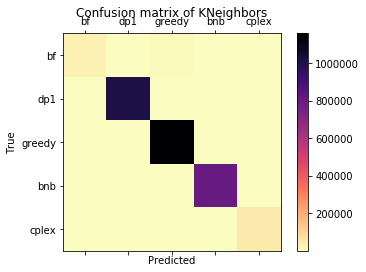

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap="magma_r")
plt.title('Confusion matrix of KNeighbors')
fig.colorbar(cax)
ax.set_xticklabels(['NA', *ALGORITHMS])
ax.set_yticklabels(['NA', *ALGORITHMS])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

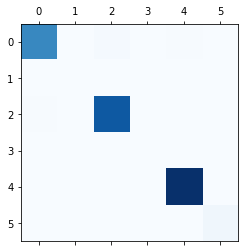

In [36]:
fig, ax = plt.subplots()

ax.matshow(cm, cmap=plt.cm.Blues)

In [26]:
set(y_test)

{0, 1, 3, 4}

In [ ]:
sample = np.array(X_test[0])
sample = (np.expand_dims(sample,0))
predictions_single = model.predict(sample)

print(predictions_single)

In [ ]:
y_test[0]